# Detecting and Mitigating Age Bias on Credit Decisions 

The goal of this tutorial is to introduce the basic functionality of [AI Fairness 360](https://aif360.mybluemix.net), an open source toolkit developed by IBM for bias mitigation. 

### Biases and Machine Learning

A machine learning model predicts an outcome for a particular instance. For example, given an instance of a loan application, we may use a model to predict whether the applicant will repay the loan. The model makes predictions based on a training dataset, where many other instances (other loan applications) and observed outcomes (whether a loan was repaid) are provided. A machine learning algorithm will attempt to find patterns, or generalizations, in the training dataset to use when a prediction for a new instance is needed. For example, the model may discover a pattern whereby a person with a salary over \$40,000 and  outstanding debt of less than \$5 is very likely to repay a loan. In many domains this technique, called supervised machine learning, has worked very well.

However, a machine learning model may make predictions that, if used to make decisions, would be undesirable or even illegal. For example, a loan repayment model may determine that age plays a significant role in the prediction of repayment because the training dataset happened to have better repayment for one age group compared to another. This raises two problems: 1) the training dataset may not be representative of the true population of loan applications for all age groups, and 2) even if it is representative, it is illegal (with limited exceptions) to base loan decisions on an applicant's age, regardless of whether this improves the accuracy of predictions based on historical data.

AI Fairness 360 is a toolkit designed to help address this problem with _fairness metrics_ and _bias mitigators_.  Fairness metrics can be used to check for bias in machine learning workflows.  Bias mitigators can be used to overcome bias in the workflow to produce a more fair outcome. 

A bias detection and mitigation strategy needs to be tailored to the particular bias of interest.  More specifically, we need to define the attribute(s), called _protected attributes_, of interest.

### The Machine Learning Workflow

To understand how bias can enter a machine learning model, we first review the basics of how a model is created in a supervised machine learning process.  

![machine learning pipeline](https://drive.google.com/uc?export=view&id=1a2f6vuCpjGwG6dNMeHUZKqLlQioRL02S)

The original data contains instances, where each instance has two components: an outcome and a set of features. For example, the outcome may be whether or not a loan was repaid, and the features may be the income, age, and gender of the applicant. First, we split the original data into _training data_ and _test data_. Second, we train a machine learning algorithm on this training data to produce a machine learning model. Third, we use the trained model to make predicts for new instances, e.g. we can predict the probability of repayment for new loan applications. We typically assess the accuracy of the model on the test dataset.

Typically, this test dataset has the same format as the training dataset and often these two datasets derive from the same initial dataset. For example, a random partitioning algorithm may be used to split the initial dataset into training and test data subsets.

Bias can enter the system in any of the three steps above. The training data set may be biased if a particular outcome is overrepresented for some types of instances. The algorithm may be biased if it assigns importance to particular features in the input that we believe should not be used or if the model produces predictions that are systematically less favorable to instances with particular features. The test data set may be biased if it has observed outcomes that are unrepresentative of the broader population of instances. These examples are not exhaustive; bias can enter the machine learning process in several other ways.

These three points in the machine learning process represent stages for testing and mitigating bias. In the AI Fairness 360 codebase, we call these stages _pre-processing_, _in-processing_, and _post-processing_. Typically, we can intervene to identify or mitigate bias at any of these three stages.

### AI Fairness 360

We are now ready to utilize AI Fairness 360 (`aif360`) to detect and mitigate bias. We will use the German Credit dataset, splitting the data into a training and test dataset.  We will look for bias in the creation of a machine learning model that predicts whether an applicant should be given credit based on various features from a typical credit application. The protected attribute will be "Age", with "1" (older than or equal to 25) and "0" (younger than 25) being the values for the _privileged_ and _unprivileged_ groups, respectively.

In this notebook, we will:

1. Install and import packages and modules
2. Set bias detection options, load dataset, and split the data into training data and test data
3. Compute fairness metric on the original training dataset
5. Mitigate bias using an in-processing algorithm, called adversarial debiasing, and compute the fairness metrics under this model

At the end of the notebook, there are optional exercises to mitigate bias using a pre-processing algorithm and another algorithm of your choosing.


# Import Statements

First, we install the necessary packages. Then we import several components from the `aif360` package. We also import the GermanDataset, metrics to check for bias, and classes related to the algorithm we will use to mitigate bias.

In [1]:
%pip install numpy matplotlib seaborn
!pip install numba==0.48
!pip install aif360==0.2.2
!python -m pip install BlackBoxAuditing
!pip install tensorflow==1.13.1

In [2]:
# import all necessary packages
import numpy as np
np.random.seed(0)

from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric, DatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.explainers import MetricTextExplainer, MetricJSONExplainer

import tensorflow as tf
print(tf.__version__)

from IPython.display import Markdown, display

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import json
from collections import OrderedDict

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

1.13.1


# Load Data, Specify Protected Attribute, and Split Data

Next we'll load the German Credit Risk data and set the protected attribute to be age. We then split the original dataset into training and test data subsets. Although we'll only use the training dataset in this tutorial, a normal workflow would also use a test dataset for assessing the efficacy (accuracy, fairness, etc) during the development of a machine learning model. Finally, we create two variables to represent the privileged and unprivileged values for the age attribute.

The German Credit Risk data contains 1000 entries with 20 categorical and integer attributes prepared. In this dataset, each entry represents a person applying for a loan. Each person is classified as a "good" or "bad" credit risk. The original dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29).

Recall that a _protected attribute_ is the attribute of interest, i.e. the attribute for which you want to test bias. The _privileged class_ is a subset of protected attribute values which we define as privileged from a fairness perspective. In the German dataset, older applicants (age >= 25) are the privileged class and younger applicants (age < 25) are the unprivileged class. We therefore have binary membership in a protected group (age) and a binary classification problem (good or bad credit risk).

Let's prepare the data:

In [3]:
# note that we drop sex, which may also be a protected attribute
data_original = GermanDataset(protected_attribute_names=['age'],
                              privileged_classes=[lambda x: x >= 25],
                              features_to_drop=['personal_status', 'sex'])

data_train, data_test = data_original.split([0.7], shuffle=True)

privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

In [4]:
print("Original one hot encoded german dataset shape: ",data_original.features.shape)
print("Train dataset shape: ", data_train.features.shape)
print("Test dataset shape: ", data_test.features.shape)

Original one hot encoded german dataset shape:  (1000, 57)
Train dataset shape:  (700, 57)
Test dataset shape:  (300, 57)


The object ```dataset_orig``` is an aif360 dataset, which has some useful methods and attributes that you can explore. More documentation is available at https://aif360.readthedocs.io/en/latest/modules/datasets.html.

For now, we'll just transform the data into a pandas dataframe:

In [5]:
df, dict_df = data_original.convert_to_dataframe()

In [6]:
print("Shape: ", df.shape)
df.head(5)

Shape:  (1000, 58)


,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,status=A14,credit_history=A30,credit_history=A31,credit_history=A32,credit_history=A33,credit_history=A34,purpose=A40,purpose=A41,purpose=A410,purpose=A42,purpose=A43,purpose=A44,purpose=A45,purpose=A46,purpose=A48,purpose=A49,savings=A61,savings=A62,savings=A63,savings=A64,savings=A65,employment=A71,employment=A72,employment=A73,employment=A74,employment=A75,other_debtors=A101,other_debtors=A102,other_debtors=A103,property=A121,property=A122,property=A123,property=A124,installment_plans=A141,installment_plans=A142,installment_plans=A143,housing=A151,housing=A152,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,credit
0,6.0,1169.0,4.0,4.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,48.0,5951.0,2.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0
2,12.0,2096.0,2.0,3.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,42.0,7882.0,2.0,4.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,24.0,4870.0,3.0,4.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0


Let's take a look at our primary feature of interest, _age_, and the outcome, _credit_.

Key:  {1.0: 'Old', 0.0: 'Young'}


Text(0, 0.5, 'Frequency')

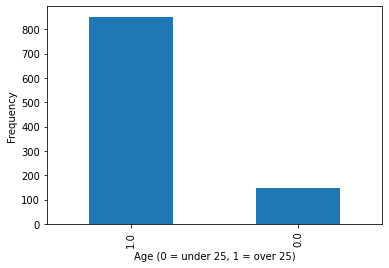

In [7]:
print("Key: ", data_original.metadata['protected_attribute_maps'][1])
df['age'].value_counts().plot(kind='bar')
plt.xlabel("Age (0 = under 25, 1 = over 25)")
plt.ylabel("Frequency")

Key:  [{1.0: 'Good Credit', 2.0: 'Bad Credit'}]


Text(0, 0.5, 'Frequency')

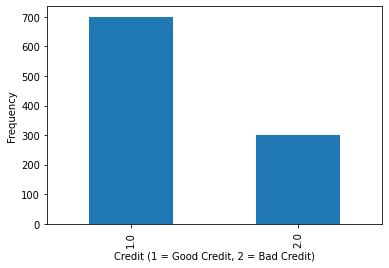

In [8]:
print("Key: ", data_original.metadata['label_maps'])
df['credit'].value_counts().plot(kind='bar')
plt.xlabel("Credit (1 = Good Credit, 2 = Bad Credit)")
plt.ylabel("Frequency")

Take a minute to explore the relationship between age category and credit. Is the mean of credit different for young and older people? What does the difference in means indicate?

age
0.0    1.409396
1.0    1.280846
Name: credit, dtype: float64


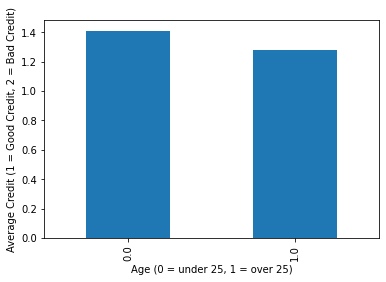

In [9]:
# STUDENT CELL
# write code to check the mean credit score by age category
dfg = df.groupby(['age'])['credit'].mean()

print(dfg)

dfg.plot(kind='bar', ylabel='Average Credit (1 = Good Credit, 2 = Bad Credit)',
         xlabel='Age (0 = under 25, 1 = over 25)')

# Compute Fairness Metrics on Original Training Data
Now that we've identified the protected attribute "age" and defined privileged and unprivileged values, we can use aif360 to detect bias in the dataset.  

## Mean Outcomes

Compare the percentage of favorable results for the privileged and unprivileged groups, subtracting the former percentage from the latter. This is equivalent to the mean difference in outcomes by group. A value of 0 indicates parity. A value less than 0 indicates less favorable outcomes for the unprivileged group.  

This is implemented in the method called ```mean_difference``` on the BinaryLabelDatasetMetric class.  The code below performs this check and displays the output.

In [10]:
metric_train = BinaryLabelDatasetMetric(
     data_train, 
     unprivileged_groups=unprivileged_groups,
     privileged_groups=privileged_groups
  )
print("Original training dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train.mean_difference())

Original training dataset
Difference in mean outcomes between unprivileged and privileged groups = -0.169905


## Disparate Impact

We can calculate the ratio of predicted favorable outcomes for the unprivileged group compared to the privileged group. A value of 1 would indicate no disparate impact. A value less than 1 implies favorable outcomes for the privileged group and a value greater than 1 implies a favorable outcomes for the unprivileged group.

In [11]:
print("Original training dataset")
print("Disparate Impact = %f" % metric_train.disparate_impact())

Original training dataset
Disparate Impact = 0.766430


## Built-In Explainers

```aif360``` has some useful "explainers" for the fairness metrics:

In [12]:
json_expl = MetricJSONExplainer(metric_train)
def format_json(json_str):
    return json.dumps(json.loads(json_str, object_pairs_hook=OrderedDict),
                      indent=2)

Let's print the mean difference explainer:

In [13]:
print(format_json(json_expl.mean_difference()))

{
  "metric": "Mean Difference",
  "message": "Mean difference (mean label value on privileged instances - mean label value on unprivileged instances): -0.1699054740619017",
  "numPositivesUnprivileged": 63.0,
  "numInstancesUnprivileged": 113.0,
  "numPositivesPrivileged": 427.0,
  "numInstancesPrivileged": 587.0,
  "description": "Computed as the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group.",
  "ideal": "The ideal value of this metric is 0.0"
}


We can also print the disparate impact explainer:

In [14]:
print(format_json(json_expl.disparate_impact()))

{
  "metric": "Disparate Impact",
  "message": "Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.7664297113013201",
  "numPositivePredictionsUnprivileged": 63.0,
  "numUnprivileged": 113.0,
  "numPositivePredictionsPrivileged": 427.0,
  "numPrivileged": 587.0,
  "description": "Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group.",
  "ideal": "The ideal value of this metric is 1.0 A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group."
}


Interpret the difference in means and disparate impact in the German Credit data:

**Write your interpretation of the difference in means and disparate impact in this text cell**

The difference in means indicates a less favorable outcome for the unprivileged group, people under 25. The disparate impact similarly indicates favorable outcomes for the privileged group, people over 25.

# Bias Mitigation via In-Processing

In-processing methods focus on the model training stage, as compared to pre-processing which focuses on transforming the data prior to model training. Broadly speaking, contemporary in-processing methods are stronger than pre-processing methods.

## Adversarial Debiasing

In this part of the notebook, we'll use an _in-processing_ algorithm called adversarial debiasing to mitigate the bias in credit prediction with respect to age that we observed in the previous section. From the aif360 [documentation](https://aif360.readthedocs.io/en/v0.2.3/modules/inprocessing.html):

> Adversarial debiasing is an in-processing technique that learns a classifier to maximize prediction accuracy and simultaneously reduce an adversary’s ability to determine the protected attribute from the predictions. This approach leads to a fair classifier as the predictions cannot carry any group discrimination information that the adversary can exploit.

For intuition, you can think of adversarial debiasing as a model with two supervised learning tasks. The first task is to predict an outcome using the training data input. The second task, i.e. the adversary, is to predict a protected feature using these predictions and non-protected features in the training data input. The aim is to maximize the model's ability to carry out the first task (i.e. predict outcomes) while minimizing it's ability to carry out the second task (i.e. predict protected features).

We implement adversarial debiasing below:

In [15]:
# reset tensorflow graph
tf.reset_default_graph()

# start tensorflow session
sess = tf.Session()

# create AdversarialDebiasing model
debiased_model = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name = 'debiased_classifier',
    debias = True,
    sess = sess)

# fit the model to training data
debiased_model.fit(data_train)

# make predictions on training and test data
data_debiasing_train = debiased_model.predict(data_train)
data_debiasing_test = debiased_model.predict(data_test)

# metrics
metric_data_debiasing_test = BinaryLabelDatasetMetric(
    data_debiasing_test, 
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
  )

# Close session
sess.close()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
epoch 0; iter: 0; batch classifier loss: 88.515305; batch adversarial loss: 0.753964
epoch 1; iter: 0; batch classifier loss: 71.864105; batch adversarial loss: 0.705678
epoch 2; iter: 0; batch classifier loss: 86.655685; batch adversarial loss: 0.729850
epoch 3; iter: 0; batch classifier loss: 59.371357; batch adversarial loss: 0.700880
epoch 4; iter: 0; batch classifier loss: 43.893822; batch adversarial loss: 0.703629
epoch 5; iter: 0; batch classifier loss: 33.120102; batch adversarial loss: 0.669069
epoch 6; iter: 0; batch classifier loss: 42.397316; batch adversari

## Fairness Metrics under Adversarial Debiasing

The adversarial debiasing algorithm has built-in methods for the difference in mean outcomes (called ```.mean_difference()```) and disparate impact (called ```.disparate_impact()```). Print these below: 

In [16]:
# write your code here 
print(f'Difference in mean outcomes between unprivileged and privileged groups = {metric_data_debiasing_test.mean_difference()}')
print(f'Disparate Impact = {metric_data_debiasing_test.disparate_impact()}')

Difference in mean outcomes between unprivileged and privileged groups = 0.0
Disparate Impact = 1.0


Interpret the difference in means and disparate impact for the predicted outcomes under adversarial debiasing. How do these compare to the metrics calculated on the original data?

**Write your interpretation and comparison in this text cell:**

The difference in means an disparate impact both indicate no bias. This illustrates how adversarial debiasing effectively removes bias from the original dataset

# Summary

The purpose of this notebook is to introduce some of the functionality of AI Fairness 360 for detecting and mitigating bias. We used an in-processing algorithm called adversarial debiasing. Below, you can run through an implementation of a pre-processing algorithm called reweighing.

There are many metrics one can use to detect the presence of bias. Likewise, there are many different bias mitigation algorithms one can employ. AI Fairness 360 provides some of them most common metrics and algorithms. In Lab 4, we will use a different package to further explore bias detection and mitigation.

Fairness metrics and mitigation algorithms can be calculated and used in the pre-processing, in-processing, and post-processing stages of the machine learning pipeline. The metrics and algorithms you use will depend, in part, on the particular fairness concerns associated with a machine learning task. We recommend incorporating bias detection in an automated continuous integration pipeline to ensure bias awareness as a project evolves.

# Optional: Bias Mitigation via Pre-Processing

_Pre-processing_ mitigation happens before the creation of the model.  

AI Fairness 360 implements several pre-processing mitigation algorithms.  We will use the **reweighing algorithm**, which is implemented in the `Reweighing` class in the `aif360.algorithms.preprocessing` package. This algorithm will transform the dataset to enhance equity in positive outcomes on the protected attribute for the privileged and unprivileged groups.

You can find documentation for reweighting here:
https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.preprocessing.Reweighing.html 


## Reweighing

Reweighing is a data preprocessing technique that generates weights for the training instances to ensure fairness before classification. The idea is to apply appropriate weights to different tuples in the training data to reduce discrimination with respect to the protected attributes. Instead of reweighing, one could also apply techniques such as suppression, i.e. removing sensitive attributes. However, the reweighing technique is generally more effective.

Call the fit and transform methods to perform the transformation, producing a newly transformed training dataset (```dataset_transf_train```):

In [17]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
data_transf_train = RW.fit_transform(data_train)

We can print the weights. Each observation in the data should have a weight. For brevity, we'll look at the weights for the first 10 rows:

In [18]:
len(data_transf_train.instance_weights)
data_transf_train.instance_weights[0:10]

array([0.96229508, 0.96229508, 0.96229508, 0.96229508, 0.96229508,
       0.96229508, 0.96229508, 0.96229508, 1.25555556, 0.678     ])

## Compute Fairness Metrics in Transformed Data

Now that we have a transformed dataset, we can check how effective it was in removing bias by calculating the same metrics we used for the original training dataset. As above, we can use the function mean_difference in the BinaryLabelDatasetMetric class:

In [19]:
# students will write code here
metric_transf_train = BinaryLabelDatasetMetric(
    data_transf_train, 
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
  )

Print the difference in mean outcomes and disparate impact in the transformed data:

In [20]:
# students will write code here
print("Transformed training dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())
print("Disparate Impact = %f" % metric_transf_train.disparate_impact())

Transformed training dataset
Difference in mean outcomes between unprivileged and privileged groups = 0.000000
Disparate Impact = 1.000000


How does this compare to the difference in mean outcomes and disparate impact in the original data?

**Write your answer in this text cell:**

The difference in means an disparate impact both indicate no bias. This shows how reweighting can also remove bias from the original dataset, but in a pre-processing fashion.

# Submitting this Lab Notebook

Once complete, please submit your lab notebook as an attachment under "Assignments > Lab 2" on Brightspace. You can download a copy of your notebook using ```File > Download .ipynb```. Please ensure you submit the `.ipynb` file (and not a `.py` file).